# RoI Pooling

Implement a ROI Pooling operator. Your code will be given the following variables:

* *input*, a mini-batch of feature maps (a torch.Tensor with shape (n, C, H, W) and dtype torch.float32)

* *boxes*, a list of bounding box coordinates on which you need to perform the ROI Pooling. *boxes* will be a list of (L,4) torch.Tensor with dtype torch.float32, where *boxes[i]* will refer to the i-th element of the batch, and contain *L* coordinates in the format (y1, x1, y2, x2)

* a tuple of integers *output_size*, containing the number of cells over which pooling is performed, in the format (heigth, width)

The code should produce an output torch.Tensor *out* with dtype torch.float32 and shape (n, L, C, output_size[0], output_size[1]).

In [22]:
import random
import torch
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle


n = random.randint(1, 3)
C = random.randint(10, 20)
H =  random.randint(8, 12)
W =  random.randint(5, 10)
oH = random.randint(2, 3)
oW = random.randint(2, 3)
L = random.randint(2, 6)  #number of boxes foreach map
input = torch.rand(n, C, H, W)
boxes = [torch.zeros(L, 4) for _ in range(n)]
for i in range(n):
  boxes[i][:, 0] = torch.rand(L) * (H-oH)       # y
  boxes[i][:, 1] = torch.rand(L) * (W-oW)       # x
  boxes[i][:, 2] = oH + torch.rand(L) * (H-oH)  # h
  boxes[i][:, 3] = oW + torch.rand(L) * (W-oW)  # w

  boxes[i][:,2:] += boxes[i][:,:2]
  boxes[i][:,2] = torch.clamp(boxes[i][:,2], max=H-1)
  boxes[i][:,3] = torch.clamp(boxes[i][:,3], max=W-1)
output_size = (oH, oW)

print("H:", H, "W:", W, "n:", n,"L:",L,"C:",C)
print(output_size)

H: 9 W: 9 n: 2 L: 6 C: 10
(2, 3)


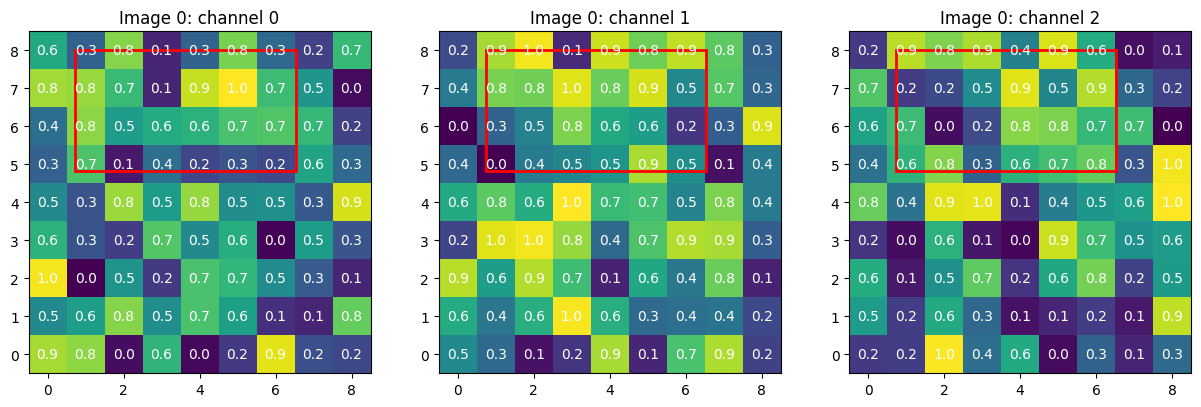

In [23]:
#let's show an example

def showMapsAndBoxes(maps:torch.Tensor, boxes:torch.Tensor, highlightCorners=False):
    """Mamps should have shape (C,H,W)"""
    numChannels = 3

    fig, ax = plt.subplots(1,numChannels,figsize=(15, 15))
    for i in range(min(maps.shape[0],numChannels)):
        example = maps[i]
        im = ax[i].imshow(example)
        #let's print boxes
        for b in boxes:
            dims = b
            x=dims[1]
            y=dims[0]
            w=dims[3] - dims[1]
            h=dims[2] - dims[0]
            ax[i].add_patch(Rectangle((x, y), w, h, fc ='none', ec ='red', lw = 2) )

            if highlightCorners:
                cornerColor='orange'

                for k in range(w+1):
                    for j in range(h+1):
                        ax[i].add_patch(Circle((x+k,y+j),0.3, fc=cornerColor, ec =cornerColor , lw = 2))
                #ax[i].add_patch(Circle((x,y),0.3, fc=cornerColor, ec =cornerColor , lw = 2))
                #ax[i].add_patch(Circle((x+w,y),0.3, fc=cornerColor, ec =cornerColor , lw = 2))
                #ax[i].add_patch(Circle((x,y+h),0.3, fc=cornerColor, ec =cornerColor , lw = 2))
                #ax[i].add_patch(Circle((x+w,y+h),0.3, fc=cornerColor, ec =cornerColor , lw = 2))

        # let's write cell values
        for k in range(example.shape[0]):
            for j in range(example.shape[1]):
                value = '%.1f' % example[k, j]
                text = ax[i].text(j, k, value,
                            ha="center", va="center", color="w")
        ax[i].set_title("Image 0: channel " + str(i))
        ax[i].set_ylim(ax[i].get_ylim()[::-1]) #reversing y axis orientation

    plt.show()


showMapsAndBoxes(input[0],boxes[0][0].unsqueeze(0))

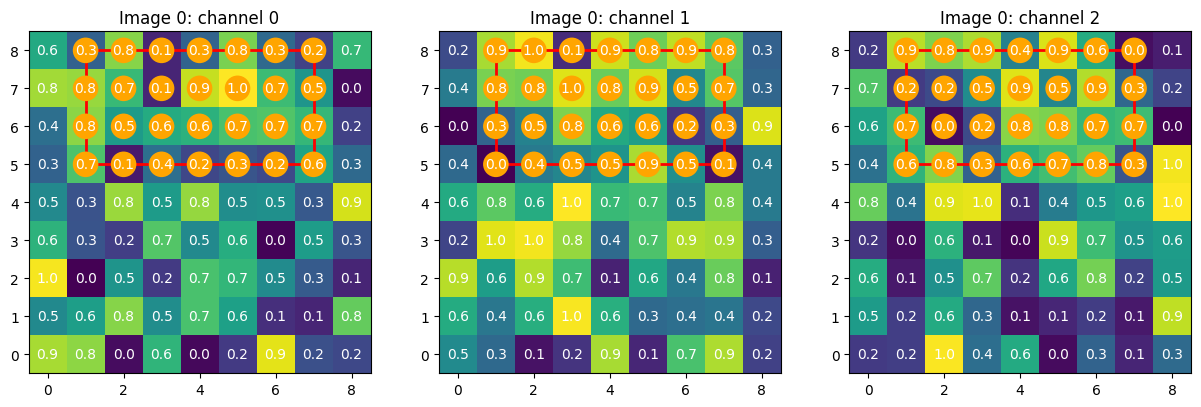

In [24]:
#lets align boxes coordinates
aligned = torch.zeros((n,L,4), dtype=torch.uint8)
for i in range(n):
    aligned[i] = torch.round(boxes[i])

showMapsAndBoxes(input[0],aligned[0][0].unsqueeze(0),True)


torch.Size([2, 6, 2, 3, 4])


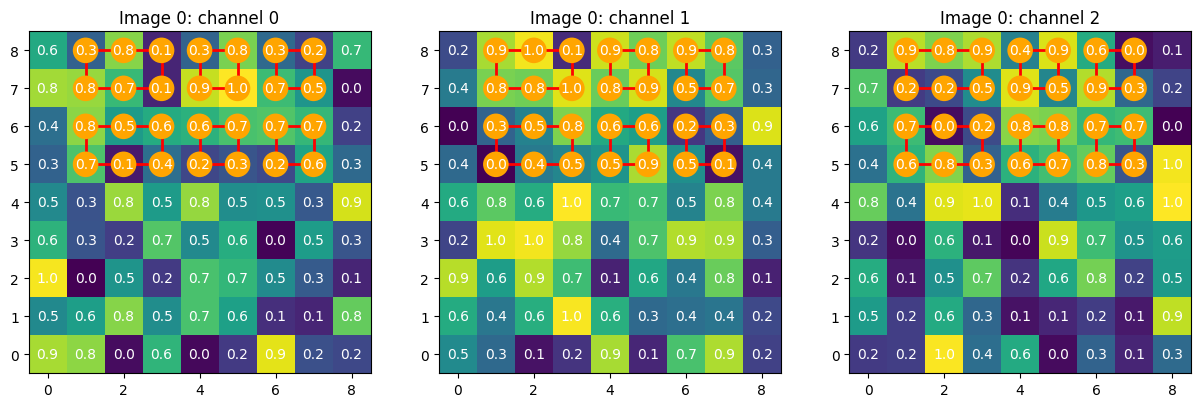

In [25]:
#now lets split a box in (oH,oW) integer subregiorns

def getSubRegions(box:torch.Tensor, output_H:int, output_W:int):
    """
    box.shape should be (n,L,4);
    output will be (n,L,output_H, output_W, 4)
    """
    x = box[:,:,1].clone().unsqueeze(-1).to(torch.float32)
    y = box[:,:,0].clone().unsqueeze(-1).to(torch.float32)
    w = (box[:,:,3] - box[:,:,1]).clone().unsqueeze(-1)
    h = (box[:,:,2] - box[:,:,0]).clone().unsqueeze(-1)

    subregions = torch.zeros((box.shape[0], box.shape[1],output_H, output_W,4), dtype=torch.uint8)
    for i in range(output_W):
        sub_w = torch.floor(w / (output_W-i))
        subregions[:,:,:,i, 1] = x
        subregions[:,:,:,i, 3] = x + sub_w
        w = w - sub_w -1
        x = x + sub_w +1
        
    for i in range(output_H):
        sub_h = torch.floor(h / (output_H-i))
        subregions[:,:,i,:, 0] = y
        subregions[:,:,i,:, 2] = y + sub_h
        h = h - sub_h -1
        y = y + sub_h +1
    return subregions

subregions = getSubRegions(aligned,output_size[0], output_size[1])
print(subregions.shape)
view = subregions.view(subregions.shape[0], subregions.shape[1],-1, 4)
showMapsAndBoxes(input[0], view[0,0] ,True)

In [26]:
#now lets pool all subregions

out = torch.zeros((n,L,C,oH,oW), dtype=torch.float32)
print(out.shape)


#how to make it more efficient?
for el in range(n):
    for l in range(L):
        for j in range(output_size[0]): #h
            for i in range(output_size[1]): #w
                min_x = subregions[el,l,j,i,1]
                min_y = subregions[el,l,j,i,0]
                max_x = subregions[el,l,j,i,3]
                max_y = subregions[el,l,j,i,2]
                out[el,l,:,j,i] = input[el, :, min_y:max_y+1, min_x:max_x+1].amax(dim=(1,2))
        


torch.Size([2, 6, 10, 2, 3])


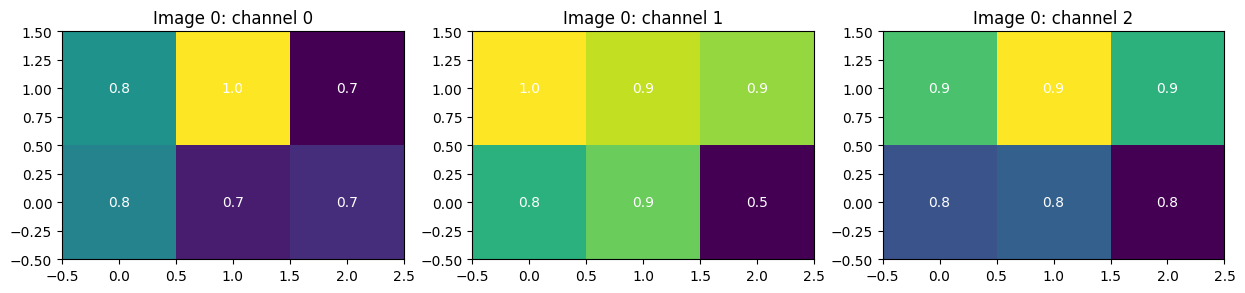

In [27]:
#lets show the final result

numChannels = 3

maps = out[0,0]

fig, ax = plt.subplots(1,numChannels,figsize=(15, 15))
for i in range(min(maps.shape[0],numChannels)):
    example = maps[i]
    im = ax[i].imshow(example)

    # let's write cell values
    for k in range(example.shape[0]):
        for j in range(example.shape[1]):
            value = '%.1f' % example[k, j]
            text = ax[i].text(j, k, value,
                        ha="center", va="center", color="w")
    ax[i].set_title("Image 0: channel " + str(i))
    ax[i].set_ylim(ax[i].get_ylim()[::-1]) #reversing y axis orientation

plt.show()